In [1]:
%cd /Volumes/ext_thumb/repos/PWC_net_tf

/Volumes/ext_thumb/repos/PWC_Net_tf


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from sintel_dataset import get_sintel_disparity_dataset, get_sintel_path
from model import build_model, pyramid_compatible_shape
import matplotlib.pyplot as plt
import time

/Volumes/ext_thumb/repos/PWC_Net_tf/env/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:38: UserWarning: You are currently using a nightly version of TensorFlow (2.4.0-dev20201023). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


In [4]:
BATCH_SIZE = 1
NUM_PYRAMID_LEVELS = 8
PREDICT_LEVEL = 2
DATASET_SHAPE = (436, 1024) # h, w
MODEL_IN_SHAPE = pyramid_compatible_shape(DATASET_SHAPE, NUM_PYRAMID_LEVELS)

model = build_model(MODEL_IN_SHAPE, NUM_PYRAMID_LEVELS, PREDICT_LEVEL, True)
model.load_weights('pwc_net_ckpts/trained_ckpt/ckpt')

Model: "PWC_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_view_image (InputLayer)    [(1, 512, 1024, 3)]  0                                            
__________________________________________________________________________________________________
right_view_image (InputLayer)   [(1, 512, 1024, 3)]  0                                            
__________________________________________________________________________________________________
preprocessing_layer (Functional (1, 512, 1024, 3)    0           left_view_image[0][0]            
                                                                 right_view_image[0][0]           
__________________________________________________________________________________________________
image_feature_extractor (Functi [(1, 512, 1024, 3),  1667916     preprocessing_layer[0][0]  

In [5]:
sintel_tfrecord_path = get_sintel_path(False)
train_ds, ds = get_sintel_disparity_dataset(sintel_tfrecord_path, BATCH_SIZE, MODEL_IN_SHAPE, NUM_PYRAMID_LEVELS)

model input shape:  (512, 1024)


In [72]:
start_time = time.time()
d = model.predict(ds.take(1))
print('inference time: {:.2f}s'.format(time.time()-start_time))

inference time: 3.03s


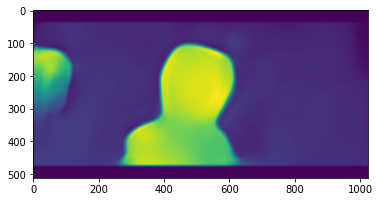

In [73]:
plt.imshow(d.squeeze())

# tflite conversion

In [7]:
import tensorflow as tf
print(tf.__version__)

2.4.0-dev20201023


In [8]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
rep_ds = list(train_ds.take(10).as_numpy_iterator())
def representative_dataset_gen():
    for i in range(10):
        inp, out = rep_ds[i]
        yield list(inp.values())
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.experimental_new_converter = True
lite_model = converter.convert()

/Volumes/ext_thumb/repos/PWC_Net_tf/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/Volumes/ext_thumb/repos/PWC_Net_tf/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1397: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: /var/folders/z5/qptv3csn3y5610hphsjgdf680000gn/T/tmpti2itvj9/assets


RuntimeError: Quantization not yet supported for op: 'CAST'.
Quantization not yet supported for op: 'CAST'.
Quantization not yet supported for op: 'FLOOR'.
Quantization not yet supported for op: 'CAST'.
Quantization not yet supported for op: 'FLOOR'.
Quantization not yet supported for op: 'CAST'.
Quantization not yet supported for op: 'FLOOR'.
Quantization not yet supported for op: 'CAST'.
Quantization not yet supported for op: 'FLOOR'.
Quantization not yet supported for op: 'CAST'.
Quantization not yet supported for op: 'FLOOR'.
Quantization not yet supported for op: 'CAST'.
Quantization not yet supported for op: 'FLOOR'.
Quantization not yet supported for op: 'CAST'.
Quantization not yet supported for op: 'FLOOR'.
Quantization not yet supported for op: 'CAST'.
Quantization not yet supported for op: 'FLOOR'.
Quantization not yet supported for op: 'CAST'.
Quantization not yet supported for op: 'FLOOR'.
Quantization not yet supported for op: 'CAST'.
Quantization not yet supported for op: 'FLOOR'.
Quantization not yet supported for op: 'CAST'.


In [9]:
tf.lite.OpsSet.TFLITE_BUILTINS_INT8

<OpsSet.TFLITE_BUILTINS_INT8: 'TFLITE_BUILTINS_INT8'>

In [25]:
lite_model_file = "pwc_net_ckpts/pwc_net_quant.tflite"
open(lite_model_file, "wb").write(lite_model)

4189760

In [7]:
import time
import numpy as np
# import tensorflow as tf # TF2

In [26]:
interpreter = tf.lite.Interpreter(
  model_path=lite_model_file)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# NxHxWxC, H:1, W:2
height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]

In [27]:
feats, depth_gt = list(ds.take(1).as_numpy_iterator())[0]

In [28]:
interpreter.set_tensor(input_details[0]['index'], feats['left_view'])
interpreter.set_tensor(input_details[1]['index'], feats['right_view'])

start_time = time.time()
nreps=10
for i in range(nreps):
    interpreter.invoke()
inf_time = (time.time()-start_time)/nreps
print('inference time: \n{:.3f}s\nfps: {:.1f}'.format(inf_time, 1/inf_time))

depth = interpreter.get_tensor(output_details[0]['index'])
depth = np.squeeze(depth)

inference time: 
0.946s
fps: 1.1


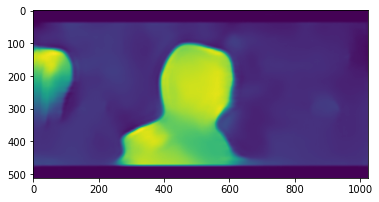

In [16]:
plt.imshow(depth)